In [1]:
import numpy as np
import keras
import scipy
import os
from IPython.display import Audio
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import random
import pylab
import wave
import sounddevice as sd
import scipy.io.wavfile as wavf

OUTPUT_DIR = "data/synthesized"
TRAINING_DIR = "data\training"
VOICE_MS = 1500
SAMPLE_MS = 10000
STRIDE = 4
FILTER_SIZE = 15

/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
import tensorflow as tf
print(tf.test.gpu_device_name())
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6143647003549706372]

In [3]:
data_dir = os.walk("data/background")
for i in data_dir:
    folders = i[1]
    break
background_noise_files = []
files = []
for i in folders:
    folder_path = os.path.join("data/background", i)
    for f in os.listdir(folder_path):
        files.append(os.path.join(folder_path, f))

In [4]:
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    #pylab.figure(num=None, figsize=(19, 12))
    #print(frame_rate) # 44100
    x = pylab.specgram(sound_info, Fs=frame_rate)
    pylab.ioff()
    #pylab.savefig('spectrogram.png')
    return x[0]
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'Int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

In [5]:
def get_random_startpoint_in_clip(clip):
    clip_length = len(clip)
    start_point = random.randint(0, clip_length - 10 * 1000)
    return start_point

def create_random_audio(audio_files, file_name):
    file_id = random.randint(0, len(audio_files)-1)
    
    background_noise = AudioSegment.from_wav(files[file_id])
    background_noise = background_noise.set_frame_rate(44100)
    start_point = get_random_startpoint_in_clip(background_noise)
    
    background_noise[start_point: start_point + (10 * 1000)].export(file_name, format="wav")
    return AudioSegment.from_file(file_name)
create_random_audio(files, "data/test.wav")
Audio("data/test.wav")

/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


866


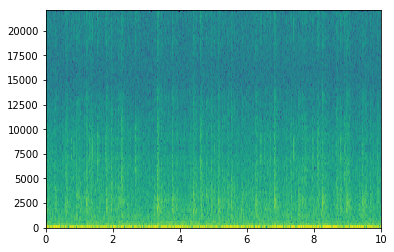

In [6]:
spec = graph_spectrogram("data/test.wav")
FREQS, SPEC_SIZE = np.shape(spec)

OUTPUT_LENGTH = round(((SPEC_SIZE + FILTER_SIZE) / STRIDE) + 1)
print(OUTPUT_LENGTH)


In [7]:
def record_sound(filename):
    duration = 1.5  # seconds
    fs = 44100
    myrecording = sd.rec(int(duration * fs), samplerate=fs, channels=2, blocking=True)
    wavf.write(filename, fs, myrecording)
    return myrecording


In [8]:


#record_sound("data/dev/neg1.wav")


In [9]:
pos_voices = [f for f in os.listdir("data/voices/pos/")]
neg_voices = [f for f in os.listdir("data/voices/neg/")]
def get_random_voice(positive_sample):
    pos_voice_index = random.randint(3, len(pos_voices))
    neg_voice_index = random.randint(1, len(neg_voices))
    path = "data/voices/pos/pos%s.wav" % pos_voice_index if positive_sample else "data/voices/neg/neg%s.wav" % neg_voice_index
    voice = AudioSegment.from_file(path)
    voice = voice[200:]
    return voice

(129, 6889)


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


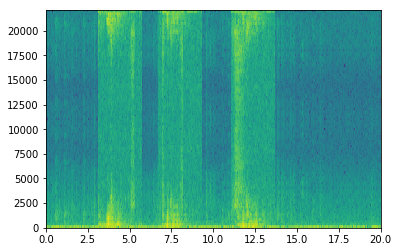

In [10]:
OUTPUT_LENGTH = 1719 # convert dim from raw spectogram to dim after 1D CONV

def is_overlap(position, prev_positions):
    pos_start = position
    pos_stop = position + VOICE_MS
    for p in prev_positions:
        prev_start = p
        prev_stop = p + VOICE_MS
        if pos_start <= prev_stop and pos_start >= prev_start or pos_stop >= prev_start and pos_stop <= prev_stop:
            return True
    return False
prev_positions = []
def add_voice_to_background(file_name, background_noise, positive):
    start_position = random.randint(0, SAMPLE_MS - VOICE_MS)
    while is_overlap(start_position, prev_positions):
        start_position = random.randint(0, SAMPLE_MS - VOICE_MS)
    #print(start_position)
    prev_positions.append(start_position)
    voice = get_random_voice(positive)
    res = background_noise.overlay(voice, position=start_position)
    res.export(file_name, format="wav")
    return (res, (start_position + VOICE_MS))


def create_training_sample(index):
    y = np.zeros(OUTPUT_LENGTH)
    file_name = "data/training/temp.wav"
    background_noise = create_random_audio(files, "data/test.wav")
    pos_samples = random.randint(2,3)
    neg_samples = random.randint(0,1)
    for i in range(pos_samples):
        background_noise, ends = add_voice_to_background(file_name, background_noise, True)
        ends = round((ends / 10000) * OUTPUT_LENGTH) # scale to output
        tends = min(OUTPUT_LENGTH, ends + 50)
        y[ends:tends] = 1
        #print(ends)
    for i in range(neg_samples):
        background_noise, ends = add_voice_to_background(file_name, background_noise, False)
        #print(ends)
    x = graph_spectrogram("data/training/temp.wav")
    print(np.shape(x))
    np.save("%s\\y%d.npy" % (TRAINING_DIR, index), y)
    np.save("%s\\x%d.npy" % (TRAINING_DIR, index), x.T)
    return (x,y)


x,y  = create_training_sample(1)
Audio("data/training/temp.wav")

(129, 6889)
(1719,)


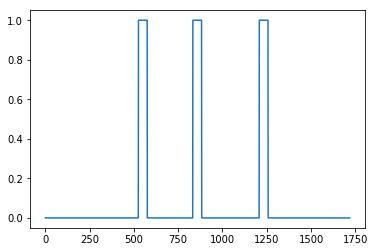

In [11]:
print(np.shape(x))
print(np.shape(y))
plt.close()
plt.plot(y)
plt.show()


In [12]:
print(TRAINING_DIR)

data	raining


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
331


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
332


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
333


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
334


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
335


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
336


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
337


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
338


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
339


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
340


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
341


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
342


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
343


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
344


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
345


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
346


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
347


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
348


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
349


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
350


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
351


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
352


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
353


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
354


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
355


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
356


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
357


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
358


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
359


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
360


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
361


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
362


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
363


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
364


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
365


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
366


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
367


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
368


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
369


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
370


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
371


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
372


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
373


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
374


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
375


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
376


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
377


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
378


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
379


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
380


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
381


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
382


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
383


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
384


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
385


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
386


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
387


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
388


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
389


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
390


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
391


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
392


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
393


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
394


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
395


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
396


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
397


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
398


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
399


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
400


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
401


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
402


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
403


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
404


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
405


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
406


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
407


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
408


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
409


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
410


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
411


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
412


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
413


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
414


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
415


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
416


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
417


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
418


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
419


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
420


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
421


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
422


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
423


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
424


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
425


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
426


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
427


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
428


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
429


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
430


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
431


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
432


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
433


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
434


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
435


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
436


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
437


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
438


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
439


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
440


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
441


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
442


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
443


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
444


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
445


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
446


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
447


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
448


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
449


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
450


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
451


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
452


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
453


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
454


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
455


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
456


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
457


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
458


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
459


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
460


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
461


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
462


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
463


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
464


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
465


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
466


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
467


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
468


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
469


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
470


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
471


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
472


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
473


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
474


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
475


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
476


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
477


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
478


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
479


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
480


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
481


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
482


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
483


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
484


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
485


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
486


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
487


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
488


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
489


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
490


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
491


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
492


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
493


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
494


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
495


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
496


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
497


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
498


/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


(129, 6889)
499


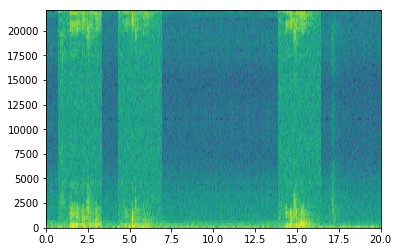

In [13]:
start_point = 331
for i in range(start_point, 500):
    prev_positions = []
    create_training_sample(i)
    print(i)

In [13]:
x_test = np.load("data/training/x1.npy")
y_test = np.load("data/training/y1.npy")
print(x_test.shape)
print(y_test.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'data/training/x1.npy'

In [27]:
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, Dropout, Activation, TimeDistributed, Dense, GRU
from keras.optimizers import Adam
def model(input_shape):
    X_input = Input(shape=input_shape)
    X = Conv1D(196, kernel_size=15, strides=4)(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(.8)(X)
    X = GRU(128, return_sequences = True)(X)
    X = Dropout(.8)(X)
    X = BatchNormalization()(X)
    X = GRU(128, return_sequences = True)(X)
    X = Dropout(.8)(X)
    X = BatchNormalization()(X)
    X = Dropout(.8)(X)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)
    return Model(inputs = X_input, outputs = X)
model = model(input_shape = (6889, 129))


In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 6889, 129)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1719, 196)         379456    
_________________________________________________________________
batch_normalization_4 (Batch (None, 1719, 196)         784       
_________________________________________________________________
activation_2 (Activation)    (None, 1719, 196)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1719, 196)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 1719, 128)         124800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1719, 128)         0         
__________

In [29]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [18]:
def load_subset(startp, stopp):
    X=[]
    Y=[]
    for i in range(startp, stopp):
        X.append(np.load("%s\\x%d.npy" % (TRAINING_DIR, i)))
        Y.append(np.load("%s\\y%d.npy" % (TRAINING_DIR, i)))
    X = np.array(X)
    Y = np.array(Y)
    Y = Y.reshape(((stopp-startp), 1719, 1))
    return X, Y

(500, 1719, 1)


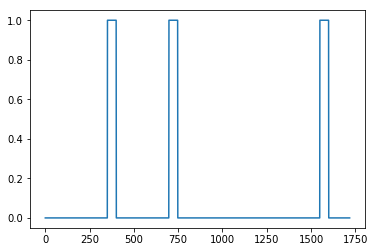

In [19]:
X, Y = load_subset(0, 500)
np.shape(Y[0])
print(np.shape(Y))
plt.plot(Y[0,:,0])

In [ ]:
print(Y[0,:,0])

In [37]:
from keras.callbacks import ModelCheckpoint
import h5py

filepath="data/weights.best.hdf5"
model.load_weights(filepath)
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

#X, Y = load_subset(i*500, (i*500)+500)
model.fit(X, Y, batch_size = 32, epochs=100, callbacks=callbacks_list)
#model.fit(X, Y, batch_size = 32, epochs=100)

AttributeError: 'function' object has no attribute 'set_model'

/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7550: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(1, 6889, 129)


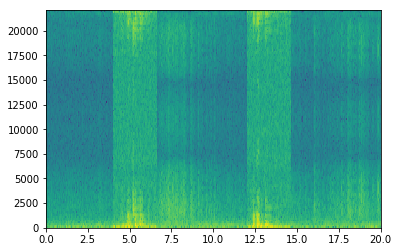

In [41]:
background = AudioSegment.from_wav("data/background/living/ch01.wav")
voice = AudioSegment.from_wav("data/dev/pos1.wav")
neg = AudioSegment.from_wav("data/dev/neg1.wav")
background = background[:10000]
background = background.overlay(voice[200:], position=2000)
background = background.overlay(neg[200:], position=6000)
background.export("data/dev.wav", format="wav")
inp = graph_spectrogram("data/dev.wav")
inp = inp.T
inp=inp.reshape((1,6889,129))
print(np.shape(inp))

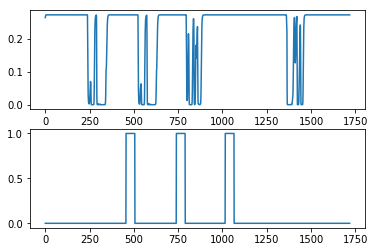

In [36]:
def plot_item():
    itemid=25
    x = X[itemid]
    y = Y[itemid]
    x = np.expand_dims(x, axis=0)
    prediction = model.predict(x)
    plt.subplot(211)
    plt.plot(prediction[0,:,0])
    plt.subplot(212)
    plt.plot(y)
plot_item()

I had to update the training set to include more positive samples. otherwise the ratio negative/positive is waay to low. It is already a sparse dataset. 
I hope this will force the model to better match positive examples


In [ ]:
I 